[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving __init__.py to __init__.py
Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving mlp.py to mlp.py
Saving model.py to model.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [6]:
batch_size = 16
max_num_context = 50
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = 10001
save_iter = 1000

In [7]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

In [8]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves()]

In [9]:
in_features = 1 
h_size = 128
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 
mc_size = 1

In [10]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size, mc_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_mu): Linear(in_features=1024, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=1024, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [11]:
opt = optim.Adam(np.parameters(), lr=5e-5) 

Iteration: 0, loss: 19.422325134277344


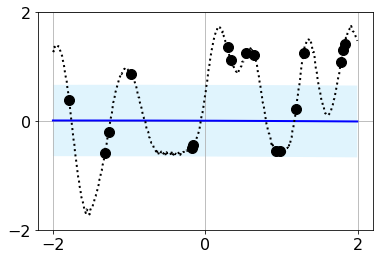

Iteration: 1000, loss: 19.132156372070312


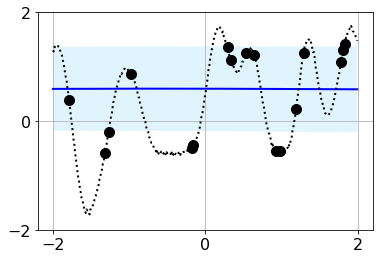

Iteration: 2000, loss: 17.3094539642334


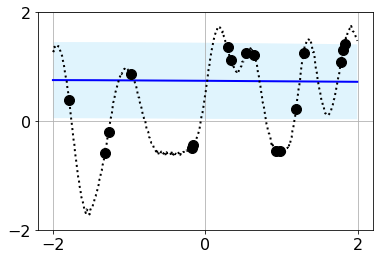

Iteration: 3000, loss: 14.899039268493652


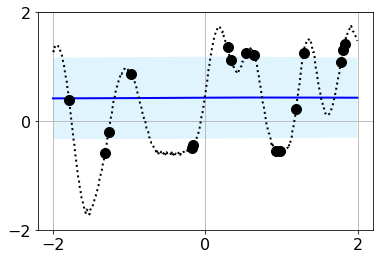

Iteration: 4000, loss: 17.173139572143555


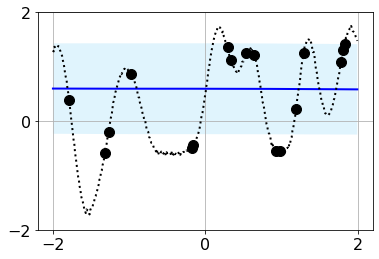

Iteration: 5000, loss: 23.25274658203125


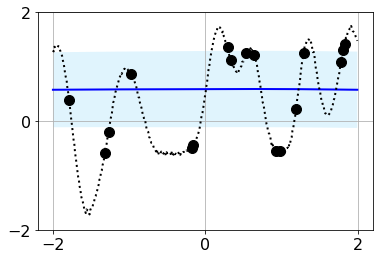

Iteration: 6000, loss: 11.520057678222656


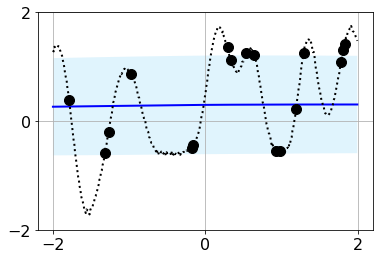

Iteration: 7000, loss: 31.792661666870117


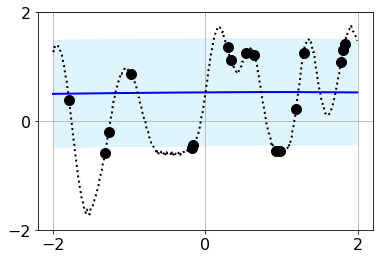

Iteration: 8000, loss: 13.986175537109375


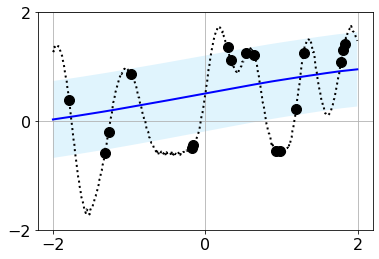

Iteration: 9000, loss: 26.167146682739258


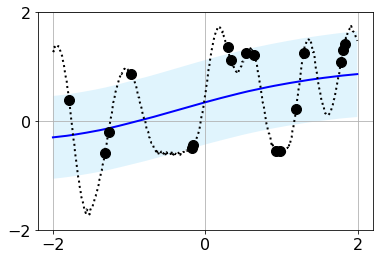

Iteration: 10000, loss: 7.23559045791626


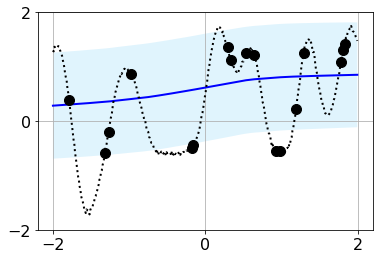

In [12]:
mu, sigma = neural_processes.utils.fit(num_iter, save_iter, np, opt, train_list, test_list)

In [13]:
train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
params = {'batch_size': 2,
          'shuffle': False,
          'num_workers': 4}

In [15]:
training_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [16]:
a = torch.rand(2, 3, 2)
b = a[0]
c = a[1]
b == c

tensor([[False, False],
        [False, False],
        [False, False]])

In [17]:
for _ in range(2):
  for local_batch, local_labels in training_generator:
    local_batch, local_labels = local_batch.to('cpu'), local_labels.to('cpu')
    print(local_batch.shape)
    print(local_batch[0] == local_batch[1])
    break
  break

torch.Size([2, 1, 28, 28])
tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,

In [18]:
x, y, xt, yt = test_list[0]

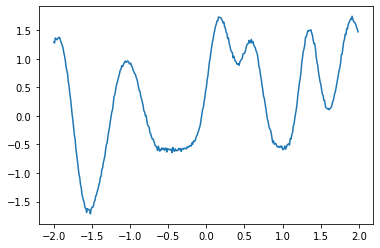

In [19]:
with torch.no_grad():
    plt.plot(xt.cpu()[0, :, 0], yt.cpu()[0, :, 0])

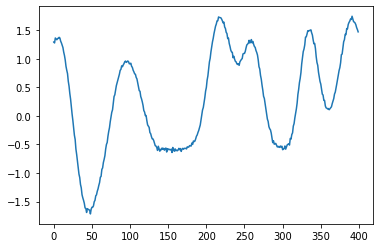

In [20]:
plt.plot(yt.squeeze().cpu().detach())

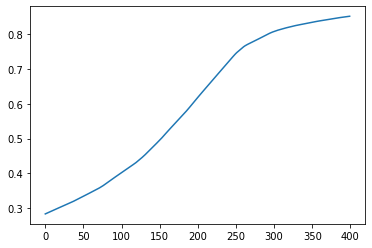

In [21]:
plt.plot(mu[0].cpu().detach())

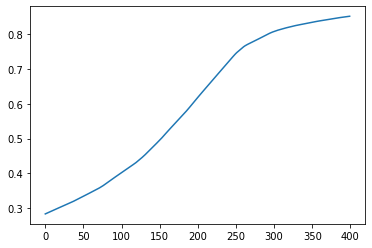

In [22]:
plt.plot(mu.cpu().squeeze())